### Flight test prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

use_onehot_encoding = False

### import data

In [2]:
training_df = pd.read_csv("../../data/flight_test/flight data.csv")
training_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
test_df = pd.read_csv("../../data/flight_test/flight test.csv")
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [4]:
total_df = pd.concat([training_df, test_df])
print('training dim', training_df.shape)
print('tes dim', test_df.shape)
print('total dim', total_df.shape)

training dim (10683, 11)
tes dim (2671, 10)
total dim (13354, 11)


In [5]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


### Data analysis

In [6]:
# checking the number of airlines in the data
training_df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

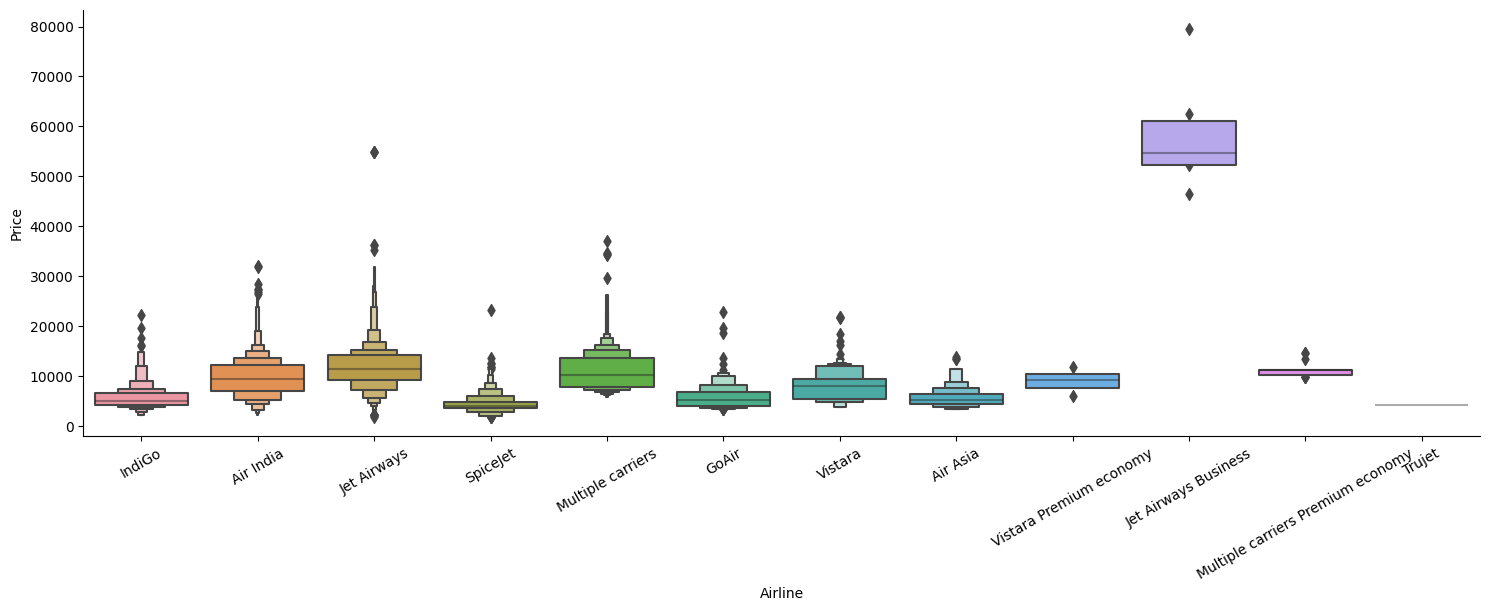

In [7]:
# price distributions by airline
plot = sns.catplot(data=training_df, x='Airline', y='Price', kind="boxen", height=5, aspect=3)
plot.set_xticklabels(rotation=30);

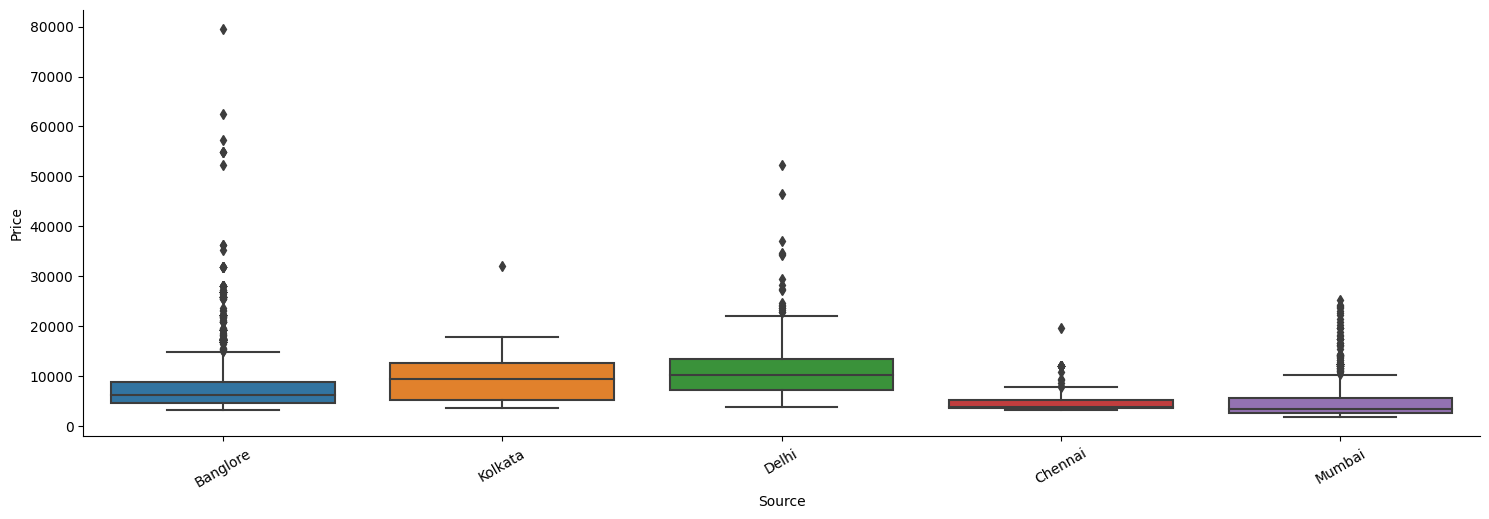

In [8]:
# price distributions by source
plot = sns.catplot(data=training_df, x='Source', y='Price', kind="box", height=5, aspect=3)
plot.set_xticklabels(rotation=30);

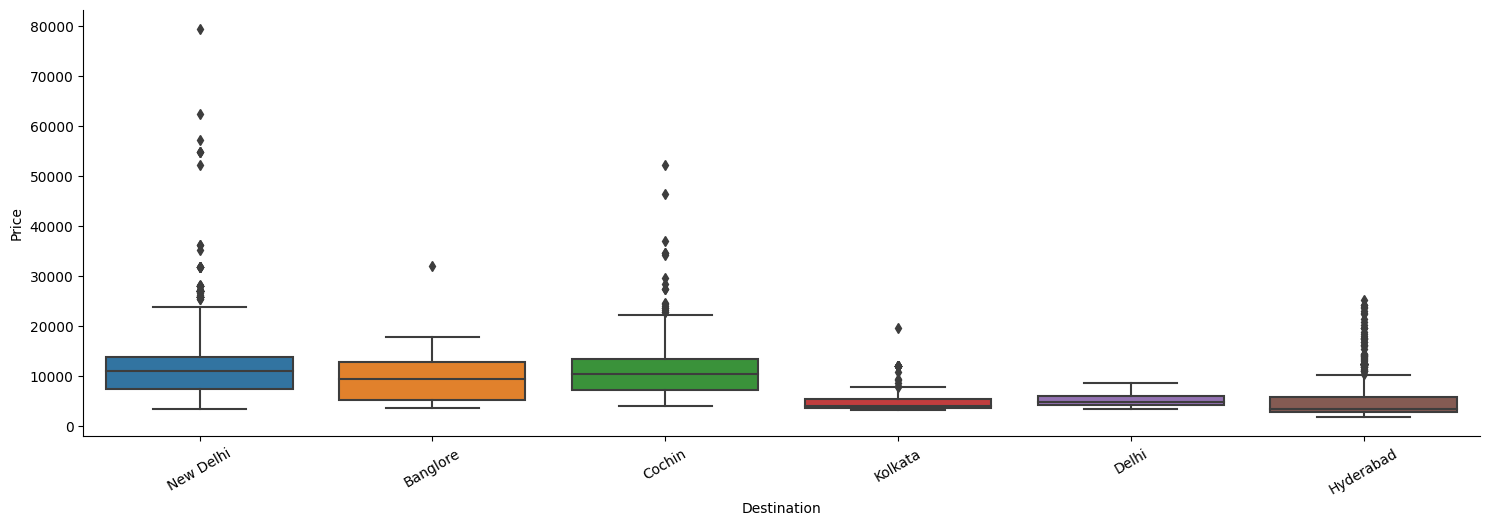

In [9]:
# price distributions by Destination
plot = sns.catplot(data=training_df, x='Destination', y='Price', kind="box", height=5, aspect=3)
plot.set_xticklabels(rotation=30);

### Feature Engineering

In [14]:
# convert date
train_df = training_df.copy()
train_df['Date_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y')
train_df['year'] = train_df['Date_of_Journey'].dt.year
train_df['month'] = train_df['Date_of_Journey'].dt.month
train_df['day'] = train_df['Date_of_Journey'].dt.day
train_df['day_of_week'] = train_df['Date_of_Journey'].dt.day_of_week
train_df.drop(['Date_of_Journey'], axis=1, inplace=True)
train_df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day,day_of_week
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,24,6
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,5,1,2
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,6,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,5,12,6
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,3,1,4


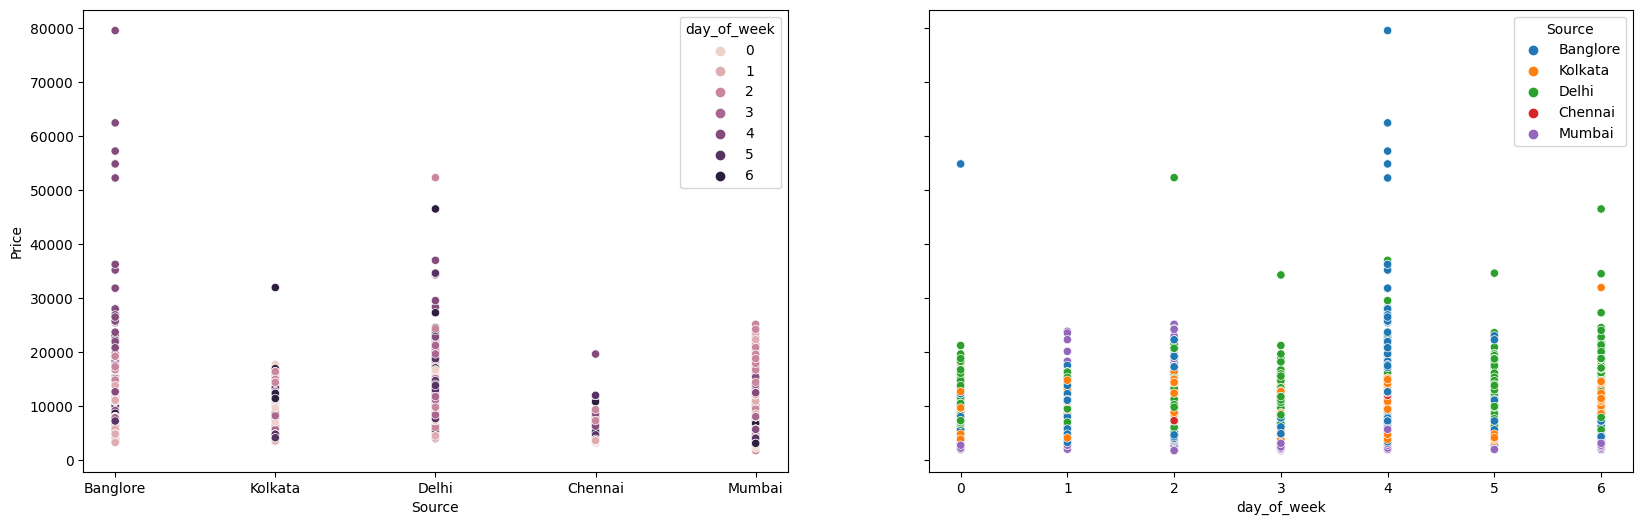

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 6))

sns.scatterplot(data=train_df, x="Source", y="Price", hue="day_of_week", ax=ax1)
sns.scatterplot(data=train_df, x="day_of_week", y="Price", hue="Source", ax=ax2);

In [30]:
# stops
if train_df['Total_Stops'].isnull().sum() > 0:
    train_df['Total_Stops'].fillna('1 stop', inplace=True)
print('Na values on stops', train_df['Total_Stops'].isnull().sum())
train_df['stops'] = train_df['Total_Stops'].apply(lambda x : 0 if x == 'non-stop' else int(x.split(' ')[0]))
train_df.drop(['Total_Stops'], axis=1, inplace=True)
train_df.head()

Na values on stops 0


,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Additional_Info,Price,year,month,day,day_of_week,stops
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,No info,3897,2019,3,24,6,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,No info,7662,2019,5,1,2,2
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,No info,13882,2019,6,9,6,2
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,No info,6218,2019,5,12,6,1
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,No info,13302,2019,3,1,4,1


In [31]:
# Arrival_Time
train_df['Arrival_Time'] = train_df['Arrival_Time'].str.split(' ').str[0]
train_df['arrival_hour'] = train_df['Arrival_Time'].str.split(':').str[0].astype(int)
train_df['arrival_min'] = train_df['Arrival_Time'].str.split(':').str[1].astype(int)
train_df.drop(['Arrival_Time'], axis=1, inplace=True)
train_df.head()

,Airline,Source,Destination,Route,Dep_Time,Duration,Additional_Info,Price,year,month,day,day_of_week,stops,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,2h 50m,No info,3897,2019,3,24,6,0,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,7h 25m,No info,7662,2019,5,1,2,2,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,19h,No info,13882,2019,6,9,6,2,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,5h 25m,No info,6218,2019,5,12,6,1,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,4h 45m,No info,13302,2019,3,1,4,1,21,35


In [32]:
# Dep_Time
train_df['dep_hour'] = train_df['Dep_Time'].str.split(':').str[0].astype(int)
train_df['dep_min'] = train_df['Dep_Time'].str.split(':').str[1].astype(int)
train_df.drop(['Dep_Time'], axis=1, inplace=True)
train_df.head()

,Airline,Source,Destination,Route,Duration,Additional_Info,Price,year,month,day,day_of_week,stops,arrival_hour,arrival_min,dep_hour,dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,No info,3897,2019,3,24,6,0,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,No info,7662,2019,5,1,2,2,13,15,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,No info,13882,2019,6,9,6,2,4,25,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,No info,6218,2019,5,12,6,1,23,30,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,No info,13302,2019,3,1,4,1,21,35,16,50


In [33]:
# Additional_Info	
train_df['Additional_Info'].value_counts() # additional info contains useful information

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [34]:
# break the route into stops -> stop1, stop2, stop3 
# using np.max, we know the number of stops possible in the flights routes as 4 so we will create stop1, stop2... stop4
def routes_to_stops(route):
    stops = str(route).split('→')
    if len(stops) < 2:
        return pd.Series(['None'] * 4)
    else:
        stops = stops[1:-1]
        remaining_legnth = 4 - len(stops)
        stops.extend(['None'] * remaining_legnth)
        return pd.Series(stops)

if 'Route' in train_df.columns:
    train_df[['stop1', 'stop2', 'stop3', 'stop4']] = train_df['Route'].apply(routes_to_stops)
    train_df.drop(['Route'], axis=1, inplace=True)

train_df.head()

,Airline,Source,Destination,Duration,Additional_Info,Price,year,month,day,day_of_week,stops,arrival_hour,arrival_min,dep_hour,dep_min,stop1,stop2,stop3,stop4,stop5
0,IndiGo,Banglore,New Delhi,2h 50m,No info,3897,2019,3,24,6,0,1,10,22,20,None,None,None,None,None
1,Air India,Kolkata,Banglore,7h 25m,No info,7662,2019,5,1,2,2,13,15,5,50,IXR,BBI,None,None,None
2,Jet Airways,Delhi,Cochin,19h,No info,13882,2019,6,9,6,2,4,25,9,25,LKO,BOM,None,None,None
3,IndiGo,Kolkata,Banglore,5h 25m,No info,6218,2019,5,12,6,1,23,30,18,5,NAG,None,None,None,None
4,IndiGo,Banglore,New Delhi,4h 45m,No info,13302,2019,3,1,4,1,21,35,16,50,NAG,None,None,None,None


In [35]:
# Duration
def duration_to_mins(duration):
    parts = duration.split(' ')
    if len(parts) == 1:
        term = parts[0]
        if 'm' in term:
            return int(term.replace('m', ''))
        elif 'h' in term:
            return 60 * int(term.replace('h', ''))
        else:
            return 0
    elif len(parts) == 2:
        return duration_to_mins(parts[0]) + duration_to_mins(parts[1])
    else:
        return 0

if 'Duration' in train_df.columns:
    train_df['flight_duration'] = train_df['Duration'].apply(duration_to_mins)
    train_df.drop(['Duration'], axis=1, inplace=True)
    
train_df.head()

,Airline,Source,Destination,Additional_Info,Price,year,month,day,day_of_week,stops,arrival_hour,arrival_min,dep_hour,dep_min,stop1,stop2,stop3,stop4,stop5,flight_duration
0,IndiGo,Banglore,New Delhi,No info,3897,2019,3,24,6,0,1,10,22,20,None,None,None,None,None,170
1,Air India,Kolkata,Banglore,No info,7662,2019,5,1,2,2,13,15,5,50,IXR,BBI,None,None,None,445
2,Jet Airways,Delhi,Cochin,No info,13882,2019,6,9,6,2,4,25,9,25,LKO,BOM,None,None,None,1140
3,IndiGo,Kolkata,Banglore,No info,6218,2019,5,12,6,1,23,30,18,5,NAG,None,None,None,None,325
4,IndiGo,Banglore,New Delhi,No info,13302,2019,3,1,4,1,21,35,16,50,NAG,None,None,None,None,285


In [36]:
# string value encoding
encoder = OneHotEncoder() if use_onehot_encoding else LabelEncoder()
train_df['Airline'] = encoder.fit_transform(train_df['Airline'])
train_df['Source'] = encoder.fit_transform(train_df['Source'])
train_df['Destination'] = encoder.fit_transform(train_df['Destination'])
train_df['Additional_Info'] = encoder.fit_transform(train_df['Additional_Info'])
train_df['stop1'] = encoder.fit_transform(train_df['stop1'])
train_df['stop2'] = encoder.fit_transform(train_df['stop2'])
train_df['stop3'] = encoder.fit_transform(train_df['stop3'])
train_df['stop4'] = encoder.fit_transform(train_df['stop4'])
train_df.head()

,Airline,Source,Destination,Additional_Info,Price,year,month,day,day_of_week,stops,arrival_hour,arrival_min,dep_hour,dep_min,stop1,stop2,stop3,stop4,stop5,flight_duration
0,3,0,5,8,3897,2019,3,24,6,0,1,10,22,20,40,25,9,1,0,170
1,1,3,0,8,7662,2019,5,1,2,2,13,15,5,50,20,1,9,1,0,445
2,4,2,1,8,13882,2019,6,9,6,2,4,25,9,25,27,3,9,1,0,1140
3,3,3,0,8,6218,2019,5,12,6,1,23,30,18,5,29,25,9,1,0,325
4,3,0,5,8,13302,2019,3,1,4,1,21,35,16,50,29,25,9,1,0,285


### Feature selection

In [37]:
# separate X => independent variables and y => dependent variable
X = train_df.drop(['Price'], axis=1)
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

In [38]:
selector = SelectFromModel(estimator=Lasso(alpha=0.005, random_state=2)).fit(X_train, y_train)

In [39]:
selector.get_support()

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True])

In [40]:
X_train.columns[selector.get_support()]

Index(['Airline', 'Source', 'Destination', 'Additional_Info', 'month', 'day',
       'day_of_week', 'stops', 'arrival_hour', 'arrival_min', 'dep_hour',
       'dep_min', 'stop1', 'stop2', 'stop3', 'flight_duration'],
      dtype='object')

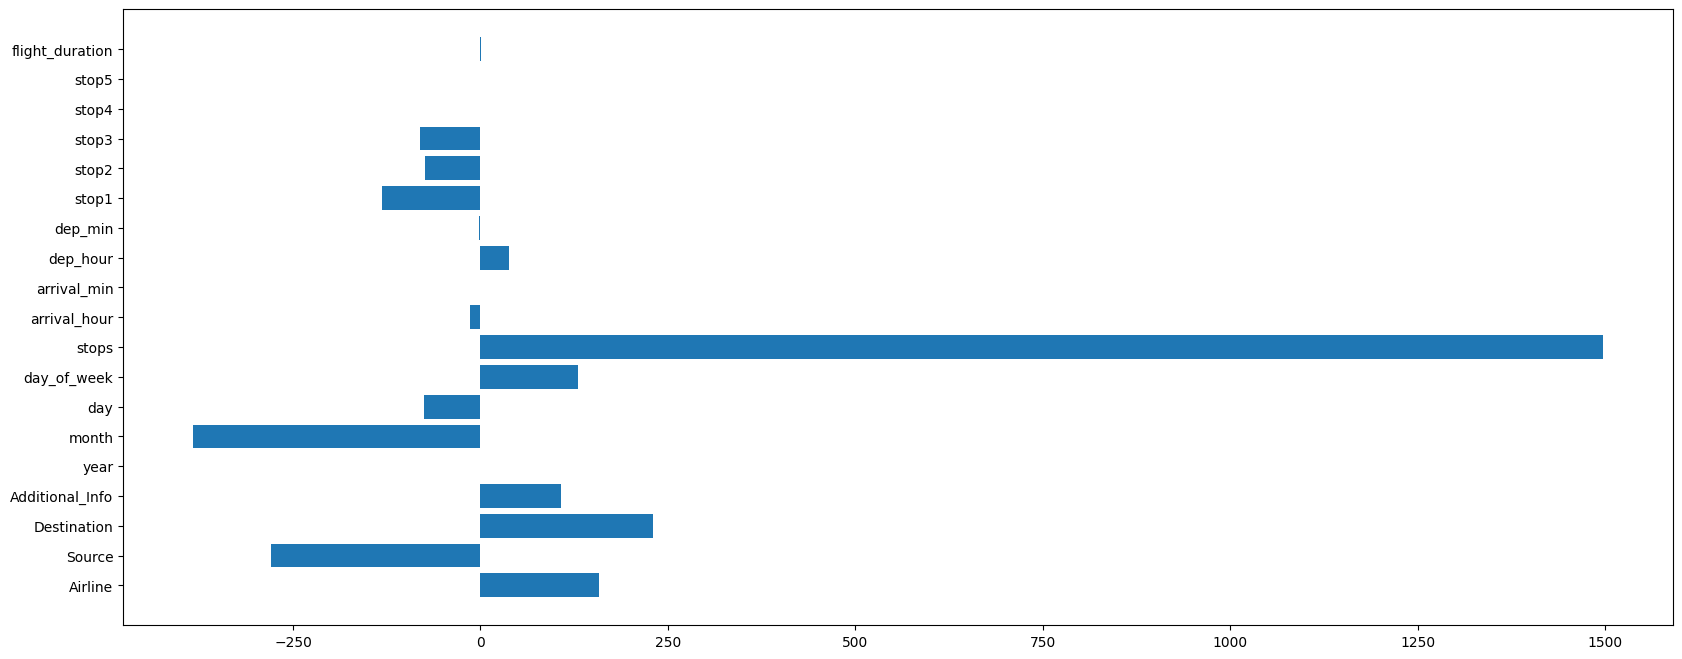

In [41]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.barh(X_train.columns, selector.estimator_.coef_);

### Model Building us Auto Sklearn

In [42]:
from autosklearn.regression import AutoSklearnRegressor

automl = AutoSklearnRegressor(time_left_for_this_task=1200)
automl.fit(X_train, y_train)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=360)

In [43]:
automl.leaderboard(top_k=10)

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
40,1,0.38,gradient_boosting,0.108135,9.592312
20,2,0.20,gradient_boosting,0.109734,42.865910
43,3,0.30,gradient_boosting,0.110281,8.452349
8,4,0.06,extra_trees,0.128819,36.431678
18,5,0.06,gradient_boosting,0.129717,2.004578


In [44]:
automl.show_models()

{8: {'model_id': 8,
  'rank': 1,
  'cost': 0.12881945079945756,
  'ensemble_weight': 0.06,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f4d12d5f550>,
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f4cd7f2ef10>,
  'regressor': <autosklearn.pipeline.components.regression.RegressorChoice at 0x7f4cd5c247f0>,
  'sklearn_regressor': ExtraTreesRegressor(max_features=0.9797793053686011, min_samples_split=4,
                      n_estimators=512, n_jobs=1, random_state=1,
                      warm_start=True)},
 18: {'model_id': 18,
  'rank': 2,
  'cost': 0.1297165029622943,
  'ensemble_weight': 0.06,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f4cd6a55ee0>,
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f4cd61fe220>,
  'regressor': <autosklearn.

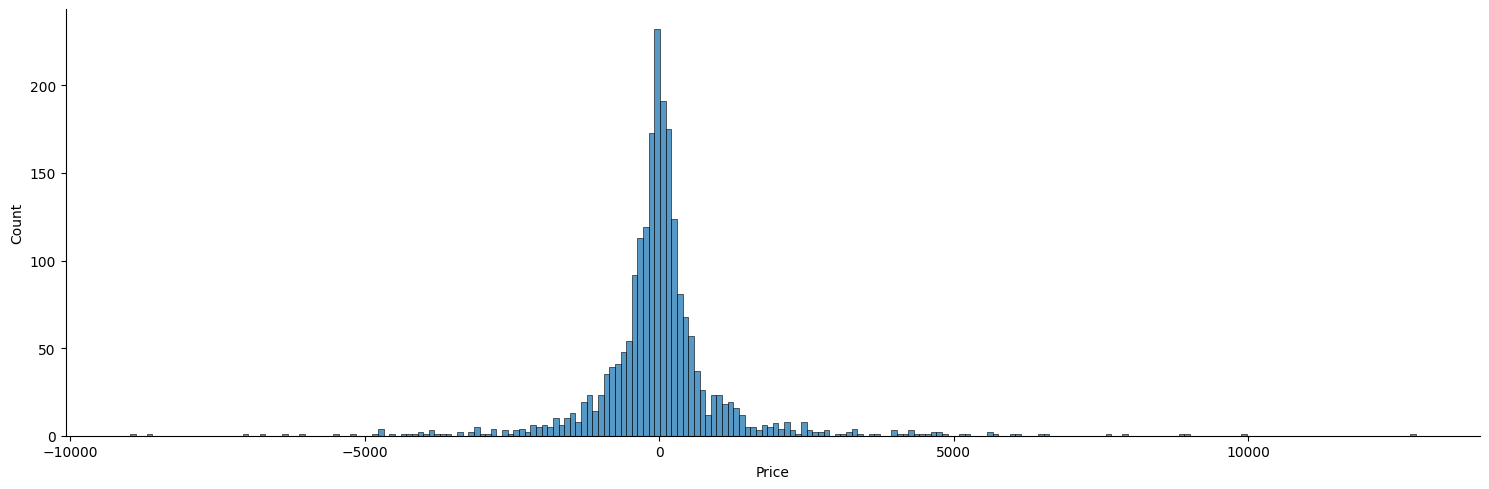

In [45]:
# begin prediction
y_pred = automl.predict(X_test)
y_error = y_test - y_pred

sns.displot(y_error, height=5, aspect=3, kind='hist');

In [46]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

print(f'Mean absolute error is {round(mean_absolute_error(y_test, y_pred), 4)}')
print(f'Mean absolute percentage error is {round(mean_absolute_percentage_error(y_test, y_pred), 4)}')
print(f'Mean square error is {round(mean_squared_error(y_test, y_pred), 4)}')
print(f'Root mean square error is {round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)}')
print(f'Root mean square error is {round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)}')
print(f'R2 score is {round(r2_score(y_test, y_pred), 4)}')


Mean absolute error is 645.8019
Mean absolute percentage error is 0.0745
Mean square error is 1490099.3565
Root mean square error is 1220.6963
Root mean square error is 1220.6963
R2 score is 0.9255
